# CS 135 day07: Evaluating Binary Classifiers

# Objectives

* See how evaluation metrics vary over possible decision thresholds
* Learn how to use sklearn utilities to compute ROC curves and confusion matrices
* Learn how to make plots to understand different loss functions


# Outline
* [Setup: Binary classification on 1-dim. toy example](#setup)
* * Same as last time
* [Part 1: Confusion matrix at different thresholds](#part1)
* [Part 2: ROC curves and area under the curve](#part2)
* [Part 3: Zero one loss (aka error rate)](#part3)
* [Part 4: Log loss (aka cross entropy)](#part4)


We expect you'll get through the first 3 parts during the assigned class period.


# Takeaways

* Confusion matrices and their derived metrics (ACC, TPR, TNR, etc) require selecting a threshold
* * Default threshold in sklearn is 0.5
* * This default is not always the best one to pick depending on your application

* ROC curves allow us to visualize what the classifier can achieve across possible thresholds
* * Look at tradeoffs between TPR and FPR
* * Area under the ROC curve (abbreviated AUROC) is a single score often used to measure classifier quality
* * AUROC is not sensitive to the scale of the predicted probabilities, only their relative ranking

* Log loss (aka binary cross entropy) 
* * Can be used to directly assess quality of predicted probabilities (no threshold needed)
* * Justified as upper bound of error rate (zero one loss with threshold 0.5)
* * Might have some numerical issues -- log(0.0) -- that you want to avoid in practice

In [ ]:
import numpy as np

In [ ]:
import sklearn.linear_model
import sklearn.neighbors

In [ ]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

<a id="setup"></a>

# Setting up a simple classification task with 1-dim features

Let's think about a classification task where:

Each input is just scalar $x$ between -1 and +1.

The "true" label assignment function is as follows:

$$
y(x) = \begin{cases} 
1 & \text{if} ~ x > 0 \\
0 & \text{otherwise}
\end{cases}
$$

The true labeling process also has some noise: after assigning a label with the above function, each example has a ~15% chance of the opposite label. 

This noise makes our classification interesting. The "best case" error rate is about ~15%.

### Make training set for 1-dim. toy example

In [ ]:
# We generated this training set for you.

N = 12

x_N = np.asarray([
    -0.975, -0.825, -0.603, -0.378, -0.284, -0.102,
     0.169,  0.311,  0.431,  0.663,  0.795,  0.976])
x_N1 = x_N.reshape((N,1)) # need an (N,1) shaped array for later use with sklearn

y_N = np.asarray([0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1])

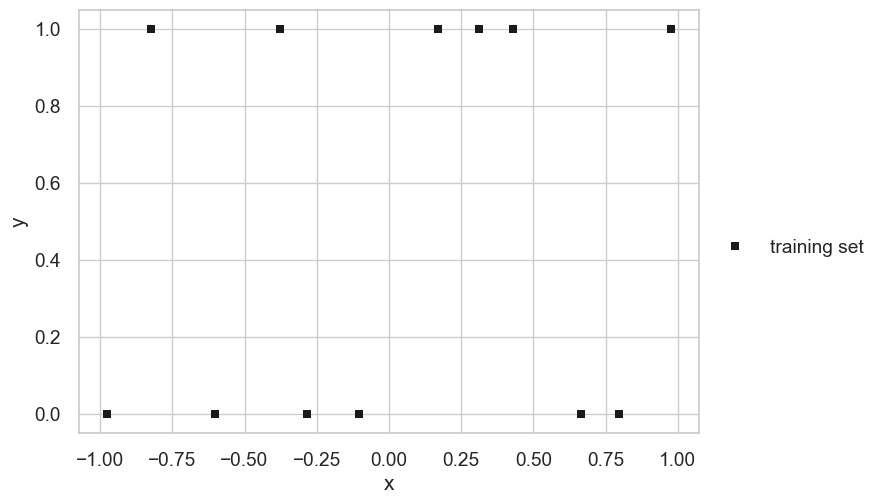

In [ ]:
plt.plot(x_N, y_N, 'ks', label='training set');
plt.xlabel('x');
plt.ylabel('y');
plt.legend(bbox_to_anchor=(1.0, 0.5));

### Make validation set for 1-d toy example

In [ ]:
def make_dataset(n_examples=10, seed=101, flip_fraction=0.15):
    N = int(n_examples)
    prng = np.random.RandomState(seed)

    # Make x values between -1 and 1, roughly evenly spaced
    x_N = np.linspace(-1, 1, N) + 0.05 * prng.randn(N)

    # Make y values such that broadly, the true function says:
    # y_n = 1  if x_n > 0 
    # y_n = 0  otherwise
    y_N = np.asarray(x_N > 0, dtype=np.int32)

    # flip a small percentage of the values
    chosen_ids = prng.permutation(np.arange(N))[:int(np.floor(flip_fraction * N))]
    y_N[chosen_ids] = 1 - y_N[chosen_ids]
    return x_N.reshape((N,1)), y_N

In [ ]:
M = 100
x_va_M1, y_va_M = make_dataset(n_examples=M, seed=201)

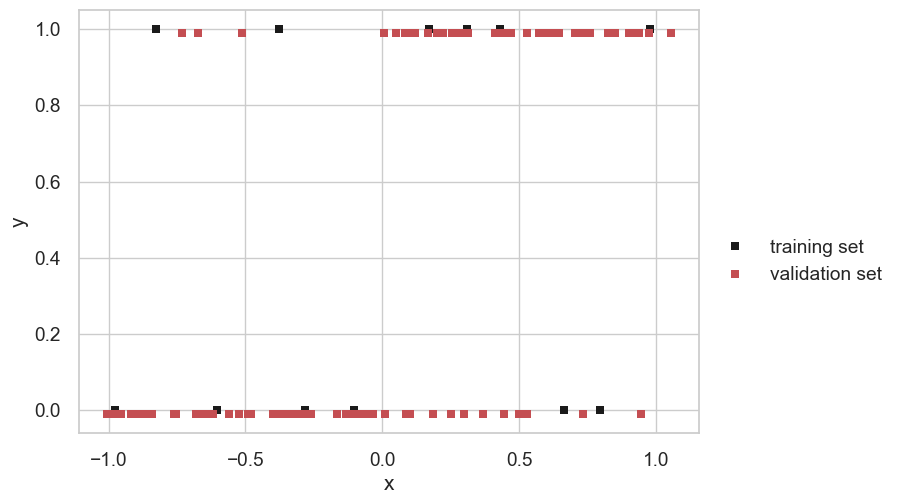

In [ ]:
plt.plot(x_N, y_N, 'ks', label='training set');
plt.plot(x_va_M1, y_va_M - 0.01, 'rs', label='validation set'); # add small vertical offset so you can see

plt.xlabel('x');
plt.ylabel('y');
plt.legend(bbox_to_anchor=(1.0, 0.5));

<a id="part1"></a>

# Setup: Train a logistic regression model for F=1 data

Here, we'll fit a Logistic Regression probabilistic classifier to the above 1-dim. feature dataset.

In [ ]:
# We'll use C = 10000.0 for now. You could select it like any hyperparameter on validation data.

lr = sklearn.linear_model.LogisticRegression(C=10000.0, l1_ratio=0);

In [ ]:
lr.fit(x_N1, y_N)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",10000.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`m

# Setup: Train a k-nearest neighbors model for F=1 data

Here, we'll fit a K Nearest probabilistic classifier to the above 1-dim. feature dataset.

In [ ]:
# We'll use K = 3 neighbors for now. In a real task, could select it like any hyperparameter on validation data.

knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3)

In [ ]:
knn.fit(x_N1, y_N)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",3
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


# Setup: Plot predicted probabilities vs feature value

We'll again use the same dense grid of L inputs to understand the predicted probability function.

In [ ]:
# Create dense grid of L input examples from -1.5 to 1.5
# so we can better understand the learned predictions
L = 101
dense_x_L1 = np.linspace(-1.5, 1.5, L).reshape((L,1))
yproba1_dense_L = lr.predict_proba(dense_x_L1)[:,1]

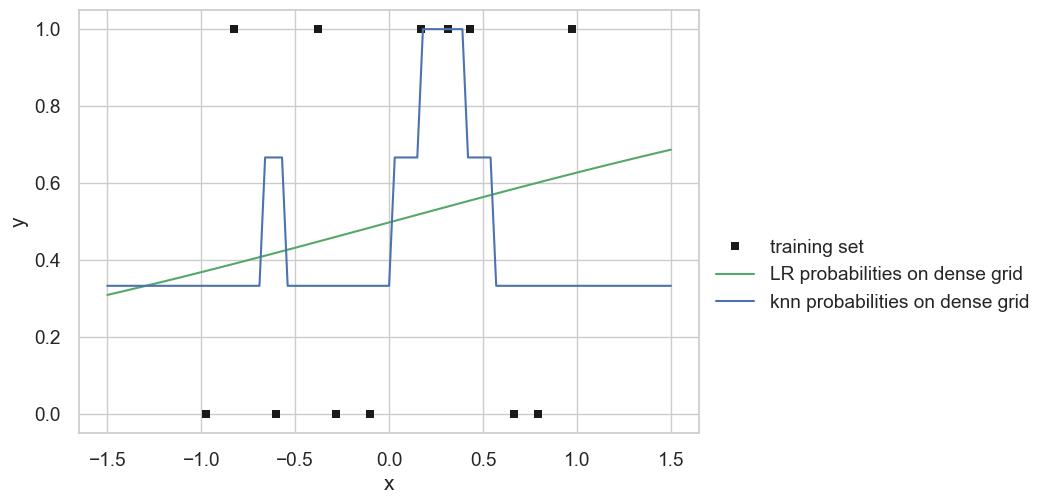

In [ ]:
plt.plot(x_N, y_N, 'ks', label='training set');

plt.plot(dense_x_L1, lr.predict_proba(dense_x_L1)[:,1], 'g-', label='LR probabilities on dense grid')
plt.plot(dense_x_L1, knn.predict_proba(dense_x_L1)[:,1], 'b-', label='knn probabilities on dense grid')

plt.xlabel('x');
plt.ylabel('y');
plt.legend(bbox_to_anchor=(1.0, 0.5));

<a id="part1"></a>

# Part 1: Computing confusion matrices on validation set

Remember, the order of the cells in a confusion matrix is like this diagram:

    | -- | -- |
    | TN | FP |
    | FN | TP |
    | -- | -- |

### Worked example: get LR classifier's predicted probabilities


In [ ]:
lr_yproba1_va_M = lr.predict_proba(x_va_M1)[:,1]

print(lr_yproba1_va_M)

[0.3707299  0.36822562 0.38134371 0.37899167 0.37426657 0.3839977
 0.37954425 0.38352674 0.38430423 0.38670724 0.38875016 0.39940746
 0.41064286 0.39857401 0.40988818 0.40238207 0.4090979  0.42428832
 0.41249588 0.42461542 0.41690936 0.41538799 0.44553107 0.43042779
 0.43501943 0.42905724 0.43378698 0.43349065 0.44513897 0.45032524
 0.45299195 0.45541044 0.44933722 0.45831816 0.45857011 0.45842505
 0.46379018 0.46070838 0.46299112 0.46347596 0.48055986 0.48076035
 0.48154235 0.48531477 0.49328092 0.4893604  0.48748782 0.47588122
 0.49902081 0.492673   0.51132645 0.49857884 0.50462696 0.51226505
 0.51153703 0.50879417 0.51390828 0.50934366 0.52004805 0.52252955
 0.53555535 0.52437684 0.53099707 0.52719207 0.53178471 0.53727022
 0.53754212 0.55199498 0.54655297 0.55665779 0.55302556 0.53941597
 0.55705483 0.56752805 0.56738894 0.56009607 0.56377282 0.57814507
 0.57538802 0.5731248  0.57667294 0.57968162 0.58034917 0.58277062
 0.59385632 0.58271324 0.59030932 0.5937017  0.5901993  0.60843

### Exercise 1a: Now, get the K-NN classifier's predicted probabilities of positive class

In [ ]:
knn_yproba1_va_M = np.zeros(M) # TODO call predict_proba on knn

### Exercise 1b: Compute LR confusion matrix at threshold of 0.5

In [ ]:
print("LR confusion at threshold 0.5")
print(sklearn.metrics.confusion_matrix(y_va_M, lr_yproba1_va_M >= 0.5))

LR confusion at threshold 0.5
[[47 11]
 [ 4 38]]


### Exercise 1c: Compute LR confusion matrix across range of thresholds 0.1, .... 0.9

In [ ]:
for thr in [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]:
    print("LR confusion at threshold %.3f" % thr)
    print(sklearn.metrics.confusion_matrix(y_va_M, lr_yproba1_va_M >= thr))

LR confusion at threshold 0.000
[[ 0 58]
 [ 0 42]]
LR confusion at threshold 0.200
[[ 0 58]
 [ 0 42]]
LR confusion at threshold 0.400
[[13 45]
 [ 0 42]]
LR confusion at threshold 0.500
[[47 11]
 [ 4 38]]
LR confusion at threshold 0.600
[[57  1]
 [33  9]]
LR confusion at threshold 0.800
[[58  0]
 [42  0]]
LR confusion at threshold 1.000
[[58  0]
 [42  0]]


### Exercise 1d: Which of the above thresholds gives the best *accuracy*?

In [ ]:
# TODO manually compute the accuracy at each threshold given printed matrices above

### Exercise 1e: Which of the above thresholds gives the best *true positive rate*?

In [ ]:
# TODO manually compute the TPR at each threshold given printed matrices above

### Exercise 1e: Does the best KNN classifier have better accuracy than the best LR?

In [ ]:
# TODO code here to print confusion matrix at several thresholds

<a id="part2"></a>

# Part 2: ROC curves

This is a brief demo of creating an ROC curve for comparing the LR and KNN classifiers from above.

In [ ]:
lr_proba1_va_M = lr.predict_proba(x_va_M1)[:,1]
knn_proba1_va_M = knn.predict_proba(x_va_M1)[:,1]

In [ ]:
lr_fpr, lr_tpr, lr_thresholds = sklearn.metrics.roc_curve(y_va_M, lr_proba1_va_M)
knn_fpr, knn_tpr, knn_thresholds = sklearn.metrics.roc_curve(y_va_M, knn_proba1_va_M)

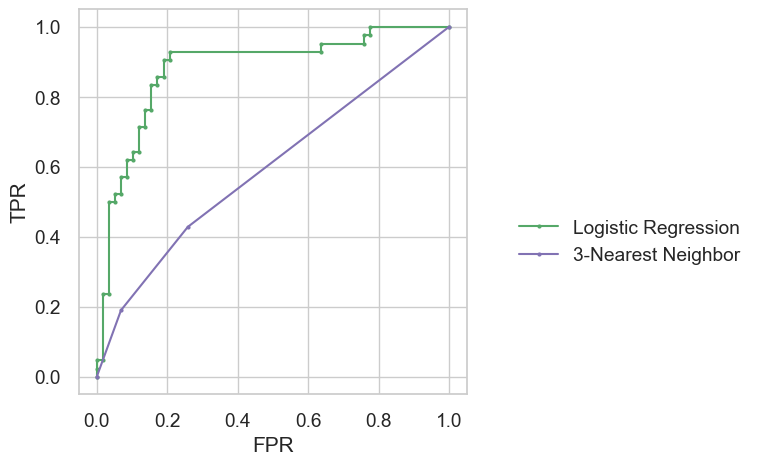

In [ ]:
plt.figure(figsize=(5,5));
plt.plot(lr_fpr, lr_tpr, 'g.-', label='Logistic Regression');
plt.plot(knn_fpr, knn_tpr, 'm.-', label='3-Nearest Neighbor');

plt.xlabel('FPR');
plt.ylabel('TPR');
plt.legend(bbox_to_anchor=(1.75, 0.5));

### Discussion 2a: Is there any FPR value where the 3-NN classifier has better TPR than the LR classifier?

In [ ]:
# TODO write your answer here, then discuss

### Exercise 2b: Visually, estimate the area under the 3-NN ROC curve above

In [ ]:
# TODO write your answer here for the 3-NN curves, by manually interpreting the plot above.

### Exercise 2c: Use sklearn functions to compute 3-NN AUROC (area under roc curve)

Use the `roc_auc_score` function, with docs here:

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html


In [ ]:
sklearn.metrics.roc_auc_score(y_va_M, np.zeros(M)) # TODO replace "zeros" array with predicted probas from 3-NN

0.5

### Exercise 2d: Suppose you multiplied all probabilities by 0.5.... what happens to the AUROC?

In [ ]:
sklearn.metrics.roc_auc_score(y_va_M, 0.5 * np.zeros(M)) # TODO replace "zeros" array with predicted probas from 3-NN

0.5

Punchline: AUROC scores are about *relative ranking*, and have little to do with the *absolute scale* of the predicted probabilities or scores

<a id="part3"></a>

# Part 3: Zero-one loss aka mean error rate

Given a predicted probability $p$, we can make a hard binary decision by *thresholding*

$$
\hat{y}(p, \tau) = \begin{cases}
1 & \text{if}~ p >= \tau
\\
0 & \text{otherwise}
\end{cases}
$$

Zero one loss as a function of predicted probability $p$

$$
\ell(p) = \begin{cases}
1 & \text{if}~ y == \hat{y}(p, \tau)
\\
0 & \text{otherwise}
\end{cases}
$$

The average zero-one loss across $N$ examples is the same as the *error rate*.

You can interpret this as fraction of mistakes.


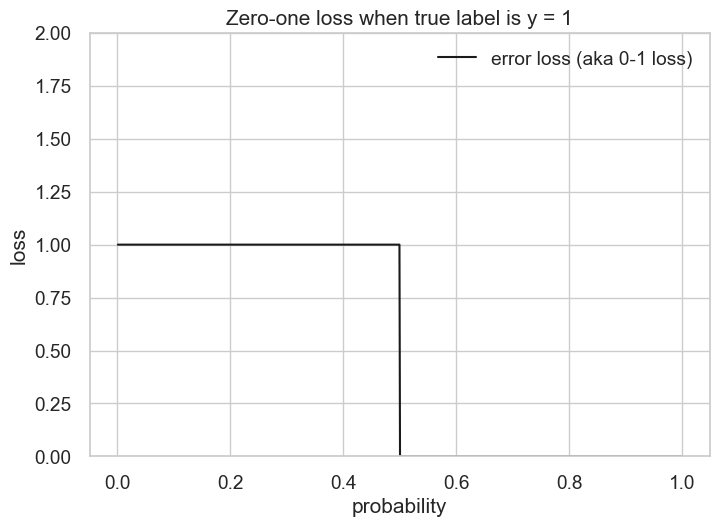

In [ ]:
# Consider loss as a function of predicted probability

ytrue = 1
thr = 0.5 # decision threshold

eps = 0.001
p_grid = np.linspace(eps, 1.0 - eps, 1000)
ytrue_grid = ytrue * np.ones_like(p_grid)

zeroone_loss_grid = np.asarray(p_grid < thr, dtype=np.float64);

plt.plot(p_grid, zeroone_loss_grid, 'k-', label='error loss (aka 0-1 loss)');
plt.legend(loc='upper right');
plt.xlabel('probability');
plt.ylabel('loss');
plt.title('Zero-one loss when true label is y = 1')
plt.ylim([0, 2.0]);

### Exercise 3a: Repeat the above but make a plot for the case that true label is y = 0

In [ ]:
# TODO copy above code here and modify appropriately

<a id="part4"></a>

# Part 4: Log loss aka binary cross entropy

The log loss for a single prediction with true label $y$ and predicted probility of positive class $p \in (0,1)$ is:
$$
\textnormal{log\_loss}(y, p) = - y \log_2 p - (1-y) \log_2 (1 - p)
$$

The output of the log loss is a real number. It must be 0.0 or greater.

The larger this loss value, the *worse* the predicted probability is.

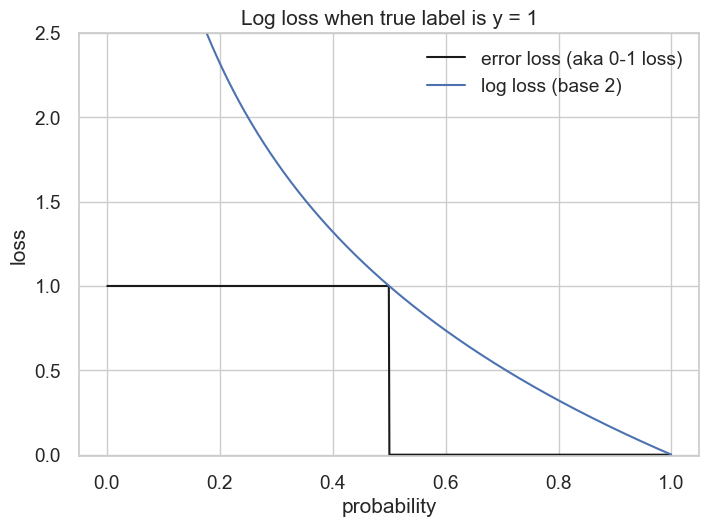

In [ ]:
# Consider loss as a function of predicted probability

ytrue = 1
thr = 0.5 # decision threshold

eps = 0.001
p_grid = np.linspace(eps, 1.0 - eps, 1000)
ytrue_grid = ytrue * np.ones_like(p_grid)

zeroone_loss_grid = np.asarray(p_grid < 0.5, dtype=np.float64);
log_loss_grid = -1 * (ytrue_grid * np.log2(p_grid) + (1-ytrue_grid) * np.log2(1-p_grid));

plt.plot(p_grid, zeroone_loss_grid, 'k-', label='error loss (aka 0-1 loss)');
plt.plot(p_grid, log_loss_grid, 'b-', label='log loss (base 2)');
plt.legend(loc='upper right');
plt.xlabel('probability');
plt.ylabel('loss');
plt.title('Log loss when true label is y = 1')
plt.ylim([-.01, 2.5]);

### Exercise 4a: Repeat the above but make a plot for the case that true label is y = 0

In [ ]:
# TODO copy above code here and modify appropriately

### Discussion 4b: What happens to log loss when the true label is 1 and predicted probability is exactly 1.0?

Recall the formula:

$$
\text{log\_loss}(y, p) = - y \log_2 p - (1-y) \log_2 (1 - p)
$$

What is the log loss at $y=1$ and $p=1$?
Is there any numerical trouble that you get into by evaluating the logarithm at this probability value?

In [ ]:
# TODO write your answer

### Discussion 4c: What happens to log loss when the true label is 1 and predicted probability is exactly 0.0?

What is the log loss at $y=1$ and $p=0.0$ (exact zero)?

Is there any numerical trouble that you get into by evaluating the logarithm at this probability value?

In [ ]:
# TODO write your answer

### Discussion 4d: How can we fix numerical issues with log(0)?

See above how we do not let $p$ go to 0.0 but instead say that the smallest probability $p$ allowed is a small positive value $\epsilon$

We assume here that $1.0 * \log(0.0)$ should be replaced by $\log(\epsilon)$ for small positive $\epsilon$

Why does this help?